## 생산공정 테스트 시간 예측하기

`(분류, 회귀 Task)`

- ML project를 위해서 사용하는 템플릿 코드를 만듭니다.

1. **필요한 라이브러리와 데이터를 불러옵니다.**


2. **EDA를 수행합니다.** 이 때 EDA의 목적은 풀어야하는 문제를 위해서 수행됩니다.


3. **전처리를 수행합니다.** 이 때 중요한건 **feature engineering**을 어떻게 하느냐 입니다.


4. **데이터 분할을 합니다.** 이 때 train data와 test data 간의 분포 차이가 없는지 확인합니다.


5. **학습을 진행합니다.** 어떤 모델을 사용하여 학습할지 정합니다. 성능이 잘 나오는 GBM을 추천합니다.


6. **hyper-parameter tuning을 수행합니다.** 원하는 목표 성능이 나올 때 까지 진행합니다. 검증 단계를 통해 지속적으로 **overfitting이 되지 않게 주의**하세요.


7. **최종 테스트를 진행합니다.** 데이터 분석 대회 포맷에 맞는 submission 파일을 만들어서 성능을 확인해보세요.

## 1. 라이브러리, 데이터 불러오기

In [150]:
# 데이터분석 4종 세트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 모델들, 성능 평가
# (저는 일반적으로 정형데이터로 머신러닝 분석할 때는 이 2개 모델은 그냥 돌려봅니다. 특히 RF가 테스트하기 좋습니다.)
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from lightgbm.sklearn import LGBMClassifier
from lightgbm.sklearn import LGBMRegressor

# 상관관계 분석, VIF : 다중공선성 제거
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.metrics import mean_squared_error

# KFold(CV), partial : optuna를 사용하기 위함
from sklearn.model_selection import KFold
from functools import partial

# hyper-parameter tuning을 위한 라이브러리, optuna
import optuna

In [131]:
# flag setting
data_reducing = False ## memory reducing technique
feature_reducing = False ## feature extraction (curse of dimensionality)

In [132]:
# 데이터를 불러옵니다.
base_path = "C:/Users/gmlkd/data/mercedes-benz-greener-manufacturing/"
train = pd.read_csv(base_path + "train.csv")
test = pd.read_csv(base_path + "test.csv")

## 2. EDA

- 데이터에서 찾아야 하는 기초적인 내용들을 확인합니다.


- class imbalance, target distribution, outlier, correlation을 확인합니다.

In [ ]:
## On your Own
data.column.value_counts()
sns.countplot()
sns.histplot()
...

In [4]:
train

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4204,8405,107.39,ak,s,as,c,d,aa,d,q,...,1,0,0,0,0,0,0,0,0,0
4205,8406,108.77,j,o,t,d,d,aa,h,h,...,0,1,0,0,0,0,0,0,0,0
4206,8412,109.22,ak,v,r,a,d,aa,g,e,...,0,0,1,0,0,0,0,0,0,0
4207,8415,87.48,al,r,e,f,d,aa,l,u,...,0,0,0,0,0,0,0,0,0,0


In [133]:
# 378개 columns 중에 object dtype는 8개 (X0,1,2,3,4,5,6,8이 object)

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4209 entries, 0 to 4208
Columns: 378 entries, ID to X385
dtypes: float64(1), int64(369), object(8)
memory usage: 12.1+ MB


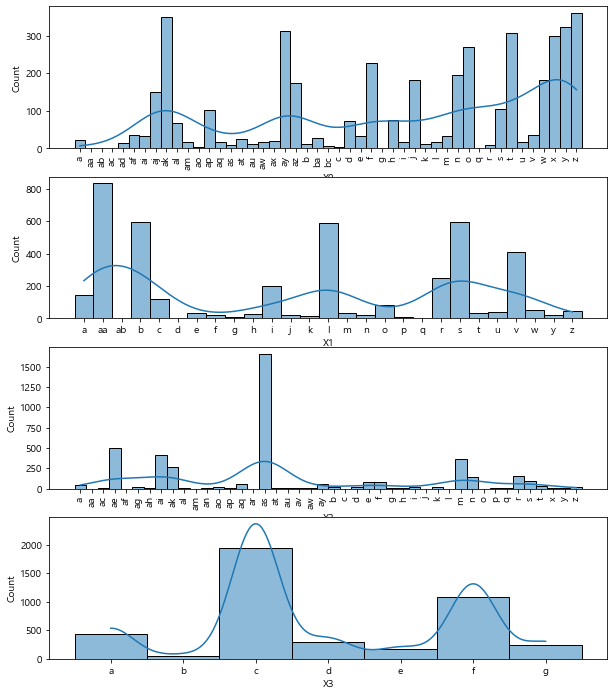

In [36]:
plt.figure(figsize=(10,12))
plt.subplot(411)
sns.histplot(data=train, x=train.X0.sort_values(), kde=True)
plt.xticks(rotation=90)

plt.subplot(412)
sns.histplot(data=train, x=train.X1.sort_values(), kde=True)

plt.subplot(413)
sns.histplot(data=train, x=train.X2.sort_values(), kde=True)
plt.xticks(rotation=90)

plt.subplot(414)
sns.histplot(data=train, x=train.X3.sort_values(), kde=True)
plt.show()

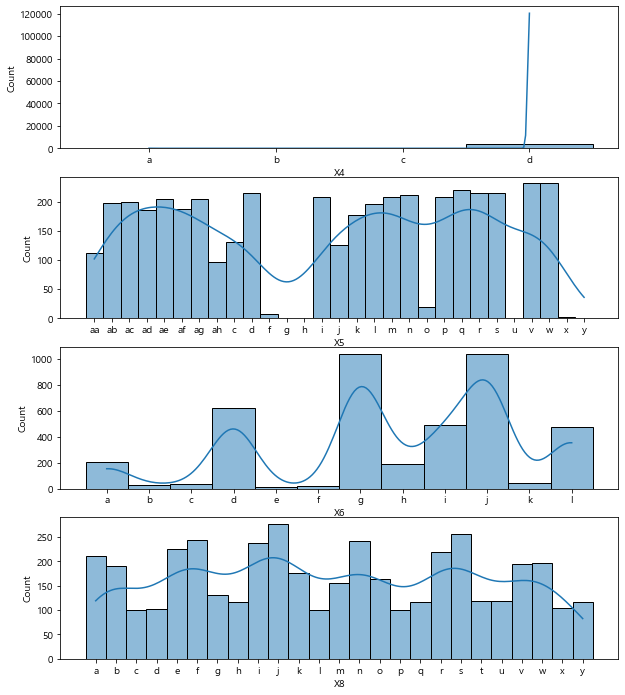

In [38]:
plt.figure(figsize=(10,12))
plt.subplot(411)
sns.histplot(data=train, x=train.X4.sort_values(), kde=True)

plt.subplot(412)
sns.histplot(data=train, x=train.X5.sort_values(), kde=True)

plt.subplot(413)
sns.histplot(data=train, x=train.X6.sort_values(), kde=True)

plt.subplot(414)
sns.histplot(data=train, x=train.X8.sort_values(), kde=True)
plt.show()

In [40]:
train.X4.value_counts()

d    4205
a       2
b       1
c       1
Name: X4, dtype: int64

<AxesSubplot:xlabel='y', ylabel='Count'>

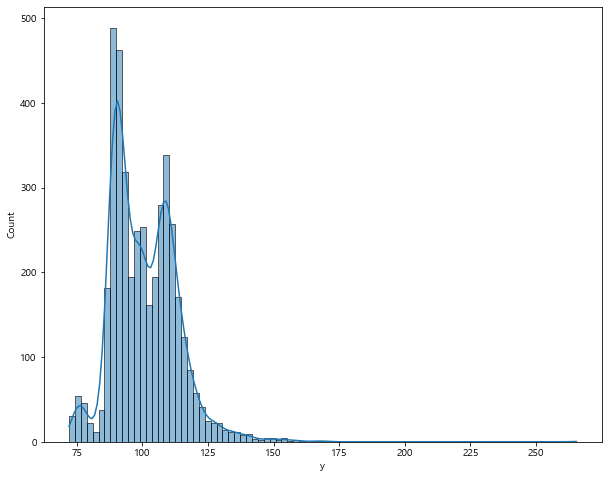

In [42]:
plt.figure(figsize=(10,8))
sns.histplot(data=train, x=train.y, kde=True)

In [43]:
train.y.describe()

count    4209.000000
mean      100.669318
std        12.679381
min        72.110000
25%        90.820000
50%        99.150000
75%       109.010000
max       265.320000
Name: y, dtype: float64

In [47]:
# X11 삭제
train.X11.value_counts()

0    4209
Name: X11, dtype: int64

In [49]:
# X347 삭제
train.X347.value_counts()

0    4209
Name: X347, dtype: int64

이런 식으로 여러가지 그래프를 그려가며, 데이터에 대한 인사이트를 얻습니다!

### 3. 전처리

#### 결측치 처리

In [134]:
# 결측치가 있는 column

train.isnull().values.any()
# 결측치는 없다.

False

In [135]:
# 중복정보가 있는 column 제거하기 위해 상관계수를 확인해봅니다.
correlated_features = train.corr().abs()
correlated_features

,ID,y,X10,X11,X12,X13,X14,X15,X16,X17,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
ID,1.000000,0.055108,0.001602,NaN,0.058988,0.031917,0.025438,0.002237,0.036480,0.038171,...,0.045229,0.080259,0.022965,0.030371,0.023382,0.013577,0.038171,0.009332,0.015355,0.029059
y,0.055108,1.000000,0.026985,NaN,0.089792,0.048276,0.193643,0.023116,0.048946,0.159815,...,0.029100,0.114005,0.061403,0.258679,0.067919,0.040932,0.159815,0.040291,0.004591,0.022280
X10,0.001602,0.026985,1.000000,NaN,0.033084,0.028806,0.100474,0.002532,0.005944,0.010164,...,0.165277,0.028618,0.074244,0.016870,0.011374,0.010479,0.010164,0.004740,0.002532,0.004387
X11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
X12,0.058988,0.089792,0.033084,NaN,1.000000,0.214825,0.246513,0.006212,0.014584,0.024937,...,0.107864,0.070214,0.030134,0.016043,0.027907,0.005566,0.024937,0.011628,0.006212,0.010765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X380,0.013577,0.040932,0.010479,NaN,0.005566,0.023045,0.007743,0.001968,0.004619,0.007899,...,0.061741,0.022240,0.061168,0.013110,0.008839,1.000000,0.007899,0.003683,0.001968,0.003410
X382,0.038171,0.159815,0.010164,NaN,0.024937,0.021713,0.012713,0.001908,0.004480,1.000000,...,0.059883,0.021571,0.059327,0.012716,0.008573,0.007899,1.000000,0.003572,0.001908,0.003307
X383,0.009332,0.040291,0.004740,NaN,0.011628,0.010125,0.023604,0.000890,0.002089,0.003572,...,0.015413,0.010059,0.035107,0.005930,0.003998,0.003683,0.003572,1.000000,0.000890,0.001542
X384,0.015355,0.004591,0.002532,NaN,0.006212,0.041242,0.025199,0.000475,0.001116,0.001908,...,0.014917,0.005373,0.008694,0.003168,0.002136,0.001968,0.001908,0.000890,1.000000,0.000824


In [137]:
upper_tri = correlated_features.where(np.triu(np.ones(correlated_features.shape),k=1).astype(np.bool_))

#### 다중공선성 처리

In [138]:
threshold = [column for column in upper_tri.columns if any(upper_tri[column] > 0.8)]
print(threshold)

['X35', 'X37', 'X39', 'X54', 'X61', 'X66', 'X76', 'X84', 'X89', 'X90', 'X94', 'X98', 'X99', 'X101', 'X102', 'X111', 'X113', 'X118', 'X119', 'X120', 'X122', 'X126', 'X128', 'X129', 'X130', 'X132', 'X134', 'X136', 'X137', 'X140', 'X146', 'X147', 'X148', 'X150', 'X157', 'X158', 'X161', 'X162', 'X166', 'X170', 'X171', 'X172', 'X178', 'X179', 'X183', 'X186', 'X187', 'X191', 'X194', 'X198', 'X199', 'X202', 'X205', 'X213', 'X214', 'X215', 'X216', 'X217', 'X219', 'X222', 'X226', 'X227', 'X229', 'X232', 'X238', 'X239', 'X241', 'X242', 'X243', 'X244', 'X245', 'X246', 'X247', 'X248', 'X249', 'X250', 'X251', 'X253', 'X254', 'X261', 'X262', 'X263', 'X264', 'X265', 'X266', 'X267', 'X272', 'X276', 'X277', 'X279', 'X296', 'X299', 'X302', 'X304', 'X308', 'X311', 'X314', 'X317', 'X320', 'X321', 'X324', 'X325', 'X326', 'X328', 'X337', 'X346', 'X348', 'X349', 'X352', 'X356', 'X357', 'X358', 'X360', 'X362', 'X363', 'X364', 'X365', 'X367', 'X368', 'X370', 'X371', 'X373', 'X374', 'X376', 'X378', 'X379', 'X38

In [141]:
# 상관계수가 threshold(e.g. 0.8)를 넘기는 feature들을 제거합니다.
train = train.drop(threshold, axis=1)

In [142]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4209 entries, 0 to 4208
Columns: 250 entries, ID to X384
dtypes: float64(1), int64(241), object(8)
memory usage: 8.0+ MB


#### Encoding Categorical Features

In [143]:
# dtype이 object인 변수들 처리.
train_OHE = pd.get_dummies(train, columns=['X0','X1','X2','X3','X4','X5','X6','X8'])
train_OHE

,ID,y,X10,X11,X12,X13,X14,X15,X16,X17,...,X8_p,X8_q,X8_r,X8_s,X8_t,X8_u,X8_v,X8_w,X8_x,X8_y
0,0,130.81,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,6,88.53,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,7,76.26,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,9,80.62,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4204,8405,107.39,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4205,8406,108.77,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4206,8412,109.22,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4207,8415,87.48,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0


#### feature extraction

- 차원의 저주를 해결하거나, 데이터의 feature 조합을 이용하는 새로운 feature를 생성할 때, PCA를 사용합니다.

- 분석에 사용할 feature를 선택하는 과정도 포함합니다.

In [144]:
# PCA 적용
from sklearn.decomposition import PCA

if feature_reducing:
    pca = PCA(n_components=0.9) # PCA(n_components=6)
    pca_data = pca.fit_transform(X)

### 4. 학습 데이터 분할

In [145]:
# 첫번째 테스트용으로 사용하고, 실제 학습시에는 K-Fold CV를 사용합니다.
# train : test = 8 : 2
from sklearn.model_selection import train_test_split

X = train_OHE.drop(columns='y')
y = train_OHE.y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0xC0FFEE)

In [146]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(3367, 436) (3367,) (842, 436) (842,)


### 5. 학습 및 평가

In [147]:
# 간단하게 LightGBM 테스트
# 적당한 hyper-parameter 조합을 두었습니다. (항상 best는 아닙니다. 예시입니다.)

param_grid = {
    "max_bin" : 20,
    "learning_rate" : 0.0025,
    "objective" : "regression",
    "boosting_type" : "gbdt",
    "metric" : "mae",
    "sub_feature" : 0.345,
    "bagging_fraction" : 0.85,
    "bagging_freq" : 40,
    "num_leaves" : 512,
    "min_data" : 500,
    "min_hessian" : 0.05,
    "verbose" : 2,
    "feature_fraction_seed" : 2,
    "bagging_seed" : 3
}

model = LGBMRegressor(**param_grid)

In [148]:
print("\nFitting LightGBM...")
model.fit(X_train, y_train)


Fitting LightGBM...
[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.345. Current value: feature_fraction=0.345
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=500. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, will be overridden by min_hessian=0.05. Current value: min_sum_hessian_in_leaf=0.05
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] bagging_freq is set=40, subsample_freq=0 will be ignored. Current value: bagging_freq=40
[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.345. Current value: feature_fraction=0.345
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=500. Current value: min_data_in_leaf

LGBMRegressor(bagging_fraction=0.85, bagging_freq=40, bagging_seed=3,
              feature_fraction_seed=2, learning_rate=0.0025, max_bin=20,
              metric='mae', min_data=500, min_hessian=0.05, num_leaves=512,
              objective='regression', sub_feature=0.345, verbose=2)

In [153]:
# metric은 그때마다 맞게 바꿔줘야 합니다.
evaluation_metric = mean_squared_error

In [155]:
print("Prediction")
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)


train_score = evaluation_metric(y_train, pred_train)
test_score = evaluation_metric(y_test, pred_test)

print("Train Score : %.4f" % train_score)
print("Test Score : %.4f" % test_score)

Prediction
Train Score : 149.5430
Test Score : 135.4698


### 6. Hyper-parameter Tuning

> GridSearchCV

** LightGBM의 hyperparameter **

[Official Documentation] https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html 

[Blog 1] https://smecsm.tistory.com/133

[Blog 2] https://towardsdatascience.com/kagglers-guide-to-lightgbm-hyperparameter-tuning-with-optuna-in-2021-ed048d9838b5

[Blog 3] https://nurilee.com/2020/04/03/lightgbm-definition-parameter-tuning/

In [156]:
# GridSearchCV를 이용하여 가장 좋은 성능을 가지는 모델을 찾아봅시다. (이것은 첫번째엔 선택입니다.)
# Lightgbm은 hyper-parameter의 영향을 많이 받기 때문에, 저는 보통 맨처음에 한번 정도는 가볍게 GCV를 해봅니다.
# 성능 향상이 별로 없다면, lightgbm으로 돌린 대략적인 성능이 이 정도라고 생각하면 됩니다.
# 만약 성능 향상이 크다면, 지금 데이터는 hyper-parameter tuning을 빡빡하게 하면 성능 향상이 많이 이끌어 낼 수 있습니다.

from sklearn.model_selection import GridSearchCV

param_grid = {
    "max_depth" : [8, 16, None],
    "n_estimators" : [100, 300, 500],
    "max_bin" : [20],
    "learning_rate" : [0.001, 0.0025, 0.003],
    "objective" : ["regression"],
    "boosting_type" : ["gbdt"],
    "metric" : ["mae"],
    "sub_feature" : [0.345],
    "bagging_fraction" : [0.7, 0.75, 0.85],
    "bagging_freq" : [40],
    "num_leaves" : [256, 512],
    "min_data" : [500],
    "verbose" : [-1], # 필수
    "min_hessian" : [0.05],
    "feature_fraction_seed" : [2],
    "bagging_seed" : [3]
}


gcv = GridSearchCV(estimator=model, param_grid=param_grid, cv=5,
                  n_jobs=-1, verbose=1)

gcv.fit(X_train, y_train)
print("Best Estimator : ", gcv.best_estimator_)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.345. Current value: feature_fraction=0.345
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=500. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, will be overridden by min_hessian=0.05. Current value: min_sum_hessian_in_leaf=0.05
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] bagging_freq is set=40, subsample_freq=0 will be ignored. Current value: bagging_freq=40
Best Estimator :  LGBMRegressor(bagging_fraction=0.85, bagging_freq=40, bagging_seed=3,
              feature_fraction_seed=2, learning_rate=0.003, max_bin=20,
              max_depth=8, metric='mae', min_data=500, min_hessian=0.05,
              n

In [158]:
print("Prediction with Best Estimator")
gcv_pred_train = gcv.predict(X_train)
gcv_pred_test = gcv.predict(X_test)

gcv_train_score = evaluation_metric(y_train, gcv_pred_train)
gcv_test_score = evaluation_metric(y_test, gcv_pred_test)

print("Train MAE Score : %.4f" % gcv_train_score)
print("Test MAE Score : %.4f" % gcv_test_score)

Prediction with Best Estimator
Train MAE Score : 113.5652
Test MAE Score : 103.9161


In [159]:
print("Performance Gain") # 이걸로 성능 향상 확인.
print("in train : ", (train_score - gcv_train_score))
print("in test : ", (test_score - gcv_test_score))

Performance Gain
in train :  35.977812352621086
in test :  31.55374233105374


> optuna를 사용해봅시다 !

In [160]:
def optimizer(trial, X, y, K):
    # 조절할 hyper-parameter 조합을 적어줍니다.
    n_estimators = 
    max_depth = 
    max_features = 
    
    
    # 원하는 모델을 지정합니다, optuna는 시간이 오래걸리기 때문에 저는 보통 RF로 일단 테스트를 해본 뒤에 LGBM을 사용합니다.
    model = RandomForestRegressor(n_estimators=n_estimators,
                                 max_depth=max_depth,
                                 max_features=max_features)
    
    
    # K-Fold Cross validation을 구현합니다.
    folds = KFold(n_splits=K)
    losses = []
    
    for train_idx, val_idx in folds.split(X, y):
        X_train = X.iloc[train_idx, :]
        y_train = y.iloc[train_idx]
        
        X_val = X.iloc[val_idx, :]
        y_val = y.iloc[val_idx]
        
        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        loss = mean_absolute_error(y_val, preds)
        losses.append(loss)
    
    
    # K-Fold의 평균 loss값을 돌려줍니다.
    return np.mean(losses)

SyntaxError: invalid syntax (1570721830.py, line 3)

In [ ]:
K = # Kfold 수
opt_func = partial(optimizer, X=X_train, y=y_train, K)

study = optuna.create_study(direction="minimize") # 최소/최대 어느 방향의 최적값을 구할 건지.
study.optimize(opt_func, n_trials=5)

In [ ]:
# optuna가 시도했던 모든 실험 관련 데이터
study.trials_dataframe()

In [ ]:
print("Best Score: %.4f" % study.best_value) # best score 출력
print("Best params: ", study.best_trial.params) # best score일 때의 하이퍼파라미터들

In [ ]:
# 실험 기록 시각화
optuna.visualization.plot_optimization_history(study)

In [ ]:
# hyper-parameter들의 중요도
optuna.visualization.plot_param_importances(study)

### 7. 테스트 및 제출 파일 생성

In [ ]:
model = RandomForestRegressor(n_estimators=study.best_trial.params["n_estimators"],
                                 max_depth=study.best_trial.params["max_depth"],
                                 max_features=study.best_trial.params["max_features"])

model.fit(X_train, y_train)
preds = model.predict(X_test)
preds

In [ ]:
X_test # 원본 데이터랑 id가 맞는지 확인 해보기!

In [ ]:
submission = pd.DataFrame() # submission을 생성합니다.
submission

In [ ]:
submission.reset_index(drop=True).to_csv("submission.csv", index=False)